# Issues faced:-
* "Store" and "Dept" are both categorical variables but the are too many categories 
* Dates of week are unique. There are 143 total unique dates which have to be replaced with week number.
* Don't know which feature is important inorder to split the data using Stratified Split.
* Averaging the MarkDowns from Nov 2011 to Oct 2012 and filling them for repective weeks from Feb 2010 to Sep 2010.
* Binary Encoding "Dept" and "Store" due to presence of large number of classes in these variables.
* One Hot Encoding the "Type" variable as it had only 3 classes.
* Changed the Boolean entries to 1 and 0 in "IsHoliday" variable.
* Scaled the numerical values using Standard Scaler.
* Implemented a pipeline to transform the data for above numberical and categorical transformations.
* Worst performance with linear regression.
* Hyperparameter tunning Random Forest Regressor, Extra Trees Regressor and XGBoost Regressor.
* Individually, the increasing order of better performace is Random Forest Regressor, XGBoost Regressor, Extra Trees Regressor.
* Tried to create a Voting Regressor of Random Forest Regressor, Extra Trees Regressor and XGBoost but the kernal is running of memory( Exceeding 16GB. The data set size if just 50 MB).
* Hence, tried out combinations of (Random Forest,Extra Trees) and (Extra Trees, XGBoost). Here, the later one performed better.
* Got the best results with Stacking well tunned XGBoost Regressor, Random Forest Regressor and Extra Trees Regressor as base estimators and Linear Regressor as final estimator.

# Some Info
* CPI  = Price of basket of goods in Given Year/Price of basket of goods in base year
* CPI is an indicator of inflation. Hence if CPI is more then people can purchase less goods in same amount of money. (https://www.investopedia.com/terms/c/consumerpriceindex.asp)
* Unemployment Rate = Percentage of unemployed people divided by the total number of people in the labour force(employed + unemployed) (https://www.investopedia.com/terms/u/unemploymentrate.asp)

# Importing all the libraries

In [1]:
# Importing data processing libraries
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from category_encoders.binary import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
import csv

# Importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model libraries 
from sklearn.ensemble import VotingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model evaluation 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Hyperparameter tunning libraries
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

# Importing Data

In [2]:
# Function to import dataset

def importData(feature = None):
    data = pd.read_csv("../input/course-material-walmart-challenge/train.csv")
    train = test = 0
    if feature is None:
        train, test = train_test_split(data, test_size = 0.2, random_state = 21)
    else:
        split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 21)
        for train_index, test_index in split.split(data, data[feature]):
            train = data.loc[train_index]
            test = data.loc[test_index]
    return [train,test]

In [3]:
# Simply splitting the data
train, test = importData("Date")

# Taking a quick look into the data

In [4]:
train.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
268185,17,16,2010-07-02,29028.63,False,68.98,2.814,NaN,NaN,NaN,NaN,NaN,126.139200,6.697,B,93188
163191,17,46,2010-04-30,25661.67,False,43.82,2.941,NaN,NaN,NaN,NaN,NaN,126.380567,6.635,B,93188
280413,17,27,2011-12-30,1838.31,True,26.73,3.119,4439.21,42391.85,120.08,1366.90,2383.67,130.071032,6.617,B,93188
266139,42,12,2012-07-06,91.28,False,86.87,3.666,156.49,NaN,9.43,NaN,876.53,130.719633,7.170,C,39690
59970,16,19,2011-06-10,338.50,False,55.78,3.735,NaN,NaN,NaN,NaN,NaN,192.847061,6.339,B,57197
116281,31,54,2010-12-31,56.84,True,47.19,2.943,NaN,NaN,NaN,NaN,NaN,211.064774,8.163,A,203750
276512,23,11,2011-03-11,17352.72,False,29.36,3.600,NaN,NaN,NaN,NaN,NaN,133.736143,5.114,B,114533
231189,23,90,2011-01-21,24254.25,False,15.58,3.232,NaN,NaN,NaN,NaN,NaN,133.028516,5.114,B,114533
275870,27,5,2011-12-16,66927.37,False,40.68,3.611,7510.92,28.09,1049.30,1160.14,7853.48,140.470079,7.906,A,204184
161447,9,6,2012-10-26,2211.29,False,69.52,3.506,512.23,3.00,8.00,NaN,1666.38,227.232807,4.954,B,125833


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225960 entries, 268185 to 172800
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         225960 non-null  int64  
 1   Dept          225960 non-null  int64  
 2   Date          225960 non-null  object 
 3   Weekly_Sales  225960 non-null  float64
 4   IsHoliday     225960 non-null  bool   
 5   Temperature   225960 non-null  float64
 6   Fuel_Price    225960 non-null  float64
 7   MarkDown1     80412 non-null   float64
 8   MarkDown2     59431 non-null   float64
 9   MarkDown3     73202 non-null   float64
 10  MarkDown4     72083 non-null   float64
 11  MarkDown5     80821 non-null   float64
 12  CPI           225960 non-null  float64
 13  Unemployment  225960 non-null  float64
 14  Type          225960 non-null  object 
 15  Size          225960 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 27.8+ MB


In [6]:
print(train['Store'].unique())
print('Total number of stores = {}'.format(len(train['Store'].unique())))

[17 42 16 31 23 27  9 45 36 24 15 35 30 11 12 25 34 44  1  6 28  4 14  7
 26 39 38 20 22 13 41 18 32 29 21  3 40  2 19 10 33 43  8 37  5]
Total number of stores = 45


In [7]:
print(train['Dept'].unique())
print('Total number of departments = {}'.format(len(train['Dept'].unique())))

[16 46 27 12 19 54 11 90  5  6 21 20 30 72 67 38 60  1 25 51 74 32 81 10
 36  8 13 22 24 59 95 33 71 92 34 91 31  4 56 23 52 28 49 26 35 79 80 44
 98 18 55 83 45 29 87 93 41 42 99  3 40  2 94 85 17  9 96  7 82 97 37 58
 48 14 77 50 78 47 65 39 43]
Total number of departments = 81


In [8]:
print('Dates of the weeks on which data was recorded :- ')
print(train['Date'].unique())
print('Total number of weeks = {}'.format(len(train['Date'].unique())))
year12 = []
year11 = []
year10 = []
date_list = train['Date'].unique()
for i in range(len(train['Date'].unique())):
    l = list(map(int, date_list[i].split('-')))
    if l[0] == 2012:
        year12.append(l[0])
    elif l[0] == 2011:
        year11.append(l[0])
    else:
        year10.append(l[0])
print('Number of Entries in Year 2010 = {}'.format(len(year10)))
print('Number of Entries in Year 2011 = {}'.format(len(year11)))
print('Number of Entries in Year 2012 = {}'.format(len(year12)))

Dates of the weeks on which data was recorded :- 
['2010-07-02' '2010-04-30' '2011-12-30' '2012-07-06' '2011-06-10'
 '2010-12-31' '2011-03-11' '2011-01-21' '2011-12-16' '2012-10-26'
 '2010-10-15' '2010-11-19' '2011-09-09' '2011-10-28' '2010-02-26'
 '2012-05-25' '2011-10-07' '2010-05-14' '2012-08-31' '2012-02-17'
 '2012-06-29' '2011-03-25' '2010-12-24' '2012-10-05' '2010-08-27'
 '2012-09-28' '2011-08-26' '2012-04-13' '2012-06-22' '2012-01-20'
 '2010-03-12' '2010-03-19' '2010-09-24' '2011-10-14' '2011-09-02'
 '2012-03-23' '2011-11-25' '2011-05-06' '2010-06-11' '2011-11-11'
 '2010-12-03' '2011-02-04' '2010-07-30' '2011-09-23' '2012-03-02'
 '2012-06-01' '2012-09-14' '2012-01-13' '2010-09-10' '2011-01-28'
 '2010-05-21' '2012-07-13' '2012-03-16' '2012-03-30' '2011-02-11'
 '2010-06-25' '2012-08-10' '2011-05-20' '2011-06-17' '2010-03-26'
 '2011-04-08' '2010-10-29' '2012-03-09' '2010-10-08' '2011-12-09'
 '2010-07-23' '2011-04-29' '2010-08-20' '2010-04-23' '2011-02-25'
 '2010-12-17' '2011-05-27'

**The entries are from February 2010 to October 2012, consisting of 143 entries. We can replace the dates by week number which will help us in visualization.**

# Replacing the "Date" variable with "Week" variable. 

In [9]:
class replaceDateWithWeek(BaseEstimator, TransformerMixin):
    def __init__(self,arg=None):
        self.arg = arg
    def fit(self,X,y=None):
        return self
    def transform(self,data,y=None):
        #Finding the dates and converting them to int
        dates_list = []
        dates = data['Date'].unique()
        print("Number of weeks in the dataset = {}".format(len(dates)))
        for i in range(len(dates)):
            l = list(map(int, dates[i].split('-')))
            dates_list.append(l)

        #Sorting the dates
        weeks = []
        for i in range(2010,2013):
            for j in range(1,13):
                for k in range(1,32):
                    for date in dates_list:
                        if date[0] == i and date[1] == j and date[2] == k:
                            weeks.append(date)

        #Reconverting the dates back to string   
        for i in range(len(weeks)):
            if weeks[i][1] >= 10 and weeks[i][2] >= 10:
                weeks[i] = str(weeks[i][0])+"-"+str(weeks[i][1])+"-"+str(weeks[i][2])
            elif weeks[i][1] >= 10 and weeks[i][2] < 10:
                weeks[i] = str(weeks[i][0])+"-"+str(weeks[i][1])+"-0"+str(weeks[i][2])
            elif weeks[i][1] < 10 and weeks[i][2] >= 10:
                weeks[i] = str(weeks[i][0])+"-0"+str(weeks[i][1])+"-"+str(weeks[i][2])
            elif weeks[i][1] < 10 and weeks[i][2] < 10:
                weeks[i] = str(weeks[i][0])+"-0"+str(weeks[i][1])+"-0"+str(weeks[i][2])

        #Replacing dates with week number
        week_num = []
        l = data['Date'].tolist()
        for i in range(len(l)):
            week_num.append(weeks.index(l[i]) + 1)

        data['Week'] = week_num
        data.drop(['Date'], axis = 1, inplace = True)
        return data
    
temp = replaceDateWithWeek()
temp.transform(train)
train.head(10)

Number of weeks in the dataset = 143


,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week
268185,17,16,29028.63,False,68.98,2.814,NaN,NaN,NaN,NaN,NaN,126.139200,6.697,B,93188,22
163191,17,46,25661.67,False,43.82,2.941,NaN,NaN,NaN,NaN,NaN,126.380567,6.635,B,93188,13
280413,17,27,1838.31,True,26.73,3.119,4439.21,42391.85,120.08,1366.90,2383.67,130.071032,6.617,B,93188,100
266139,42,12,91.28,False,86.87,3.666,156.49,NaN,9.43,NaN,876.53,130.719633,7.170,C,39690,127
59970,16,19,338.50,False,55.78,3.735,NaN,NaN,NaN,NaN,NaN,192.847061,6.339,B,57197,71
116281,31,54,56.84,True,47.19,2.943,NaN,NaN,NaN,NaN,NaN,211.064774,8.163,A,203750,48
276512,23,11,17352.72,False,29.36,3.600,NaN,NaN,NaN,NaN,NaN,133.736143,5.114,B,114533,58
231189,23,90,24254.25,False,15.58,3.232,NaN,NaN,NaN,NaN,NaN,133.028516,5.114,B,114533,51
275870,27,5,66927.37,False,40.68,3.611,7510.92,28.09,1049.30,1160.14,7853.48,140.470079,7.906,A,204184,98
161447,9,6,2211.29,False,69.52,3.506,512.23,3.00,8.00,NaN,1666.38,227.232807,4.954,B,125833,143


**The above transformation can also be done using OrdinalEncoder**

# Performing EDA

# Checking the store wise sale in 3 years

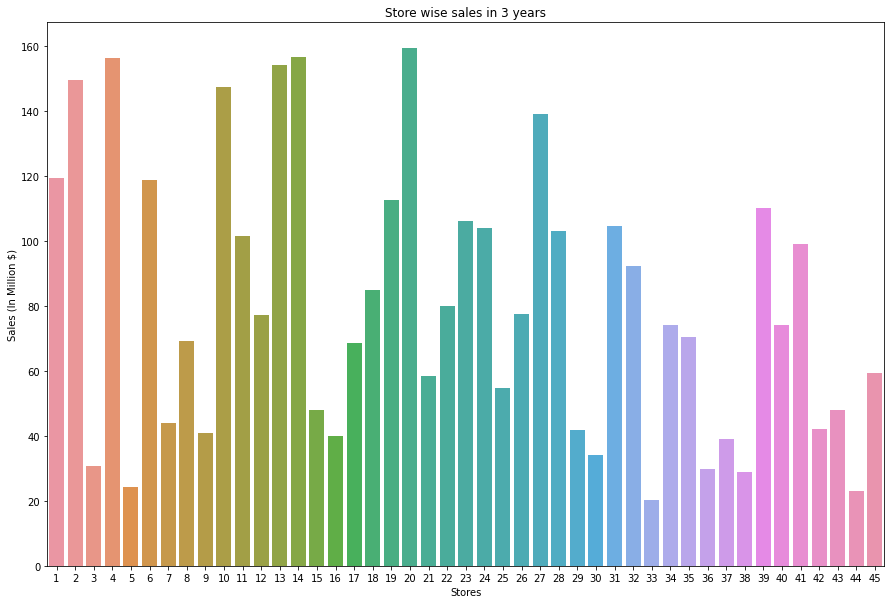

In [10]:
sales_sum = []
store_index = [i for i in range(1,46)]

for i in range(1,46):
    sales_sum.append(sum(train[train['Store'] == i]['Weekly_Sales'])/1000000)

plt.figure(figsize = (15,10))
plt.title('Store wise sales in 3 years')
sns.barplot(x = store_index, y = sales_sum)
sns.set(style = 'darkgrid')
plt.xlabel("Stores")
plt.ylabel("Sales (In Million $)")
plt.show()

***Few stores have very high sales while few have comparatively very low sales***

# Testing difference in sales on Holiday Weeks

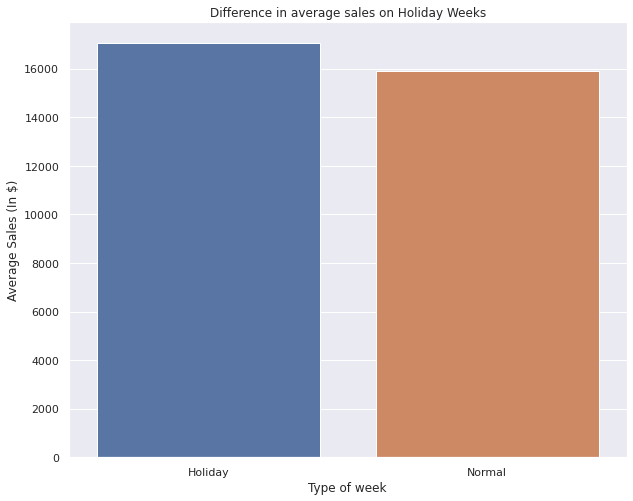

In [11]:
y = []
x = ['Holiday', 'Normal']

y.append(sum(train[train['IsHoliday'] == True]['Weekly_Sales'])/len(train[train['IsHoliday'] == True]['Weekly_Sales']))
y.append(sum(train[train['IsHoliday'] == False]['Weekly_Sales'])/len(train[train['IsHoliday'] == False]['Weekly_Sales']))

plt.figure(figsize = (10,8))
plt.title('Difference in average sales on Holiday Weeks')
sns.barplot(x = x, y = y)
sns.set(style = 'darkgrid')
plt.xlabel("Type of week")
plt.ylabel("Average Sales (In $)")
plt.show()

***Not much difference is seen in Holiday and Normal week Average Weekly Sales***

# Time Series subplot of Weekly Sales, CPI and unemployment rate

Text(0, 0.5, 'Average Unemployment')

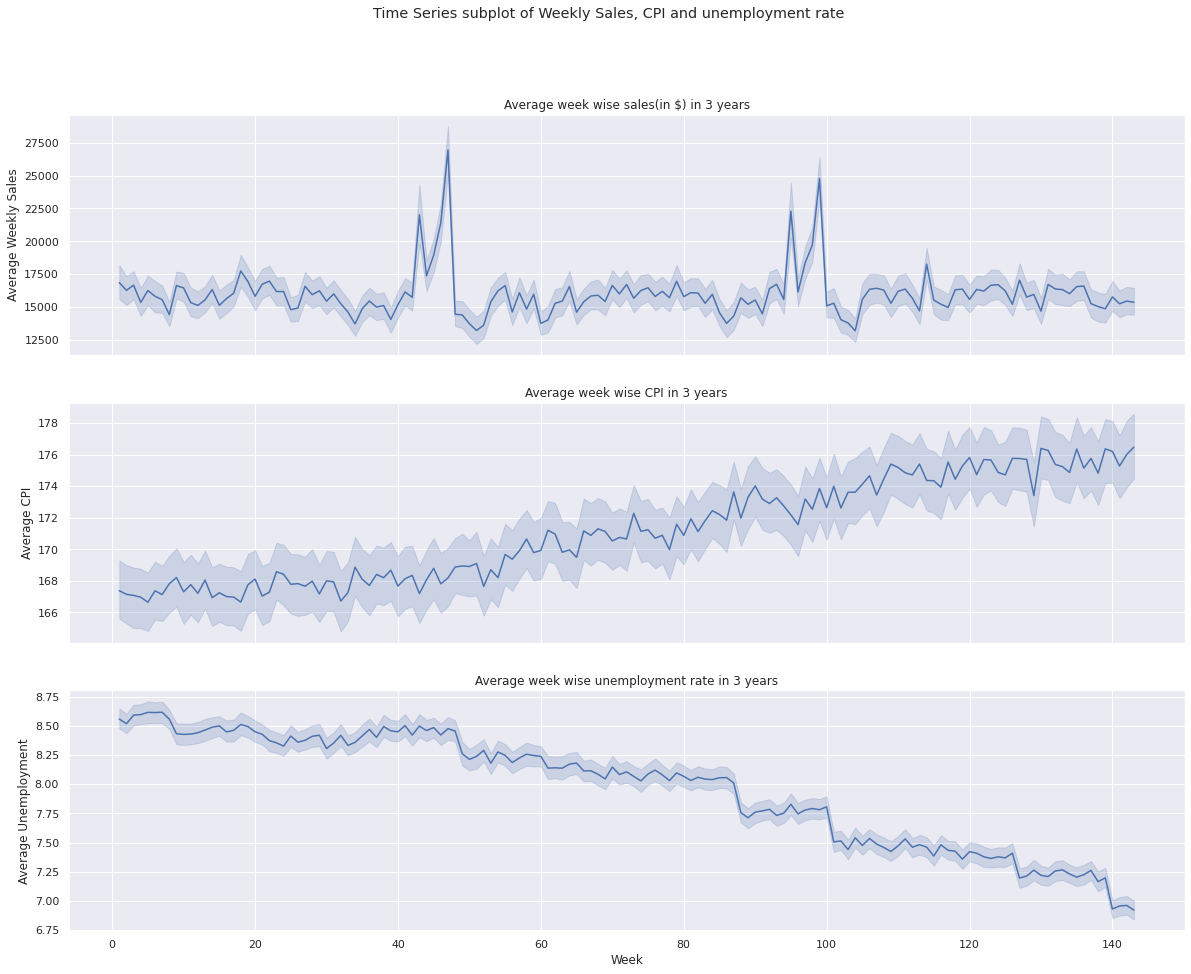

In [12]:
fig, axes = plt.subplots(3, 1, figsize = (20,15), sharex = True, sharey = False)
fig.suptitle("Time Series subplot of Weekly Sales, CPI and unemployment rate")
sns.lineplot(ax=axes[0],x = 'Week', y = 'Weekly_Sales', data=train)
axes[0].set_title("Average week wise sales(in $) in 3 years")
axes[0].set_ylabel("Average Weekly Sales")
sns.lineplot(ax=axes[1],x = 'Week', y = 'CPI', data=train)
axes[1].set_title("Average week wise CPI in 3 years")
axes[1].set_ylabel("Average CPI")
sns.lineplot(ax=axes[2],x = 'Week', y = 'Unemployment', data=train)
axes[2].set_title("Average week wise unemployment rate in 3 years")
axes[2].set_xlabel("Week")
axes[2].set_ylabel("Average Unemployment")

**The following points are observed:**
* The weekly sales have taken a jump around 48th and 100th week.
* The weekly sales have declined just after the jump.
* The CPI is increasin overall.
* The unemployment rate is decreasing overall.
* No clear correlation is seen among the three variables.( Weekly Sales, CPI, Unemployment Rate)

# Checking the temperature wise weekly sales

Text(0, 0.5, 'Average Weekly Sales')

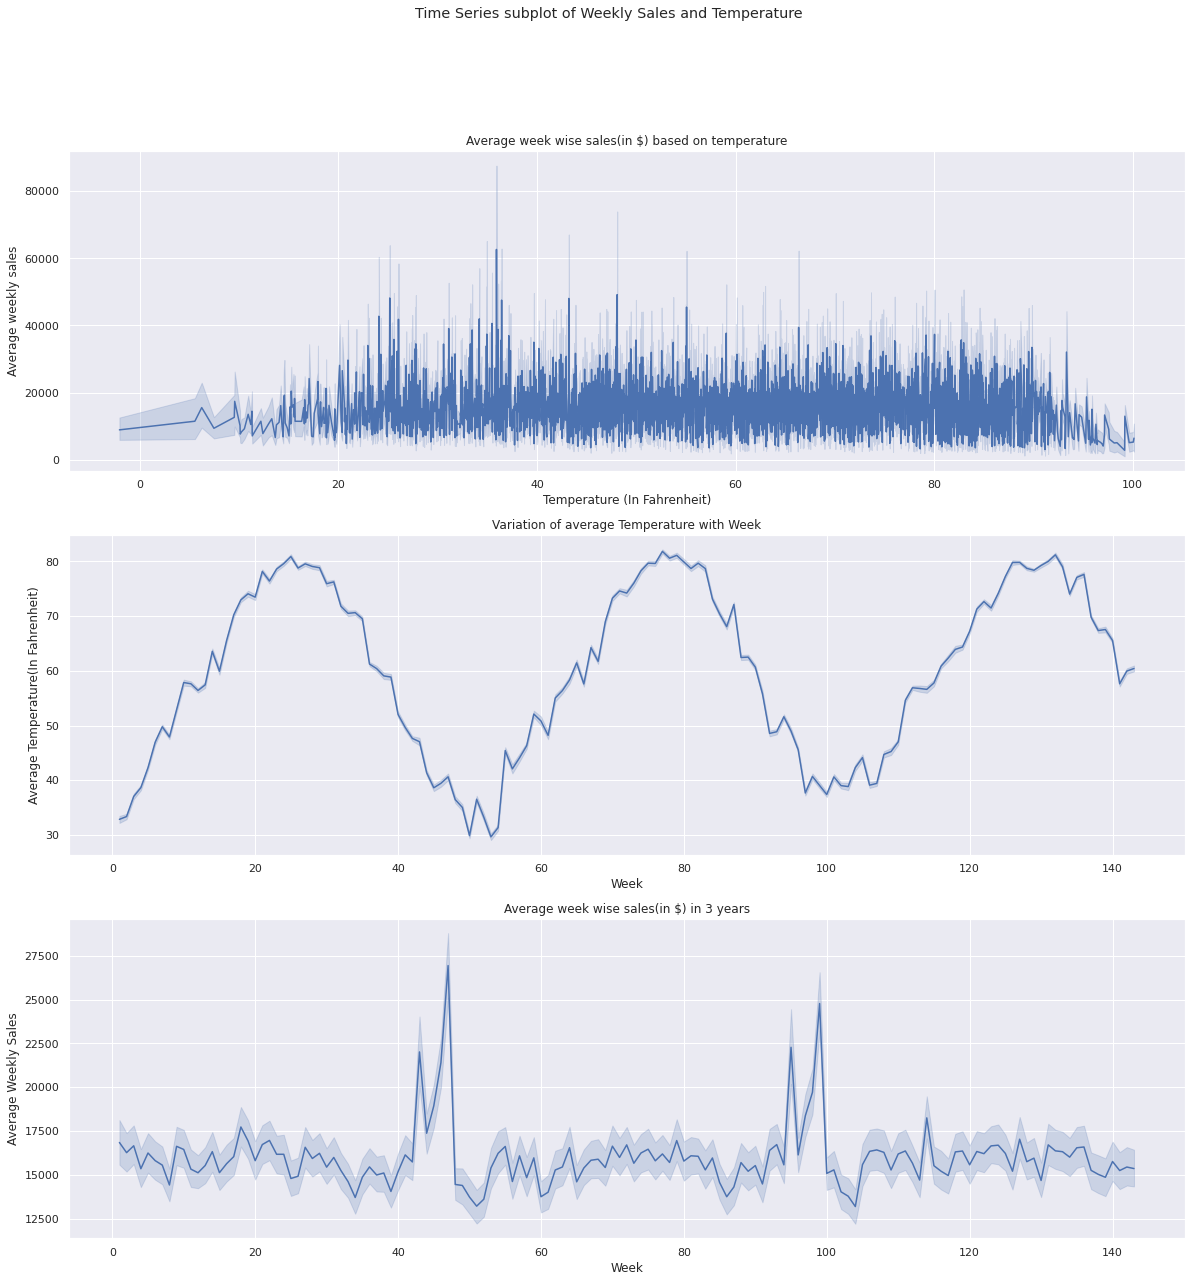

In [13]:
fig, axes = plt.subplots(3, 1, figsize = (20,20), sharex = False, sharey = False)
fig.suptitle("Time Series subplot of Weekly Sales and Temperature")
sns.lineplot(ax=axes[0],x = 'Temperature', y = 'Weekly_Sales', data=train)
axes[0].set_title("Average week wise sales(in $) based on temperature")
axes[0].set_xlabel("Temperature (In Fahrenheit)")
axes[0].set_ylabel("Average weekly sales")
sns.lineplot(ax=axes[1],x = 'Week', y = 'Temperature', data=train)
axes[1].set_title("Variation of average Temperature with Week")
axes[1].set_xlabel("Week")
axes[1].set_ylabel("Average Temperature(In Fahrenheit)")
sns.lineplot(ax=axes[2],x = 'Week', y = 'Weekly_Sales', data=train)
axes[2].set_title("Average week wise sales(in $) in 3 years")
axes[2].set_xlabel("Week")
axes[2].set_ylabel("Average Weekly Sales")

***The steep rise in the graph of Average Weekly Sales vs Week may be during Christmas (i.e in December) as the temperature is seen to be very low at that time***

# Filling up Markdowns for 2010 and 2011 based on data after Nov 2011
* The entries for MarkDowns have started from November 11, 2011 and upto October 26, 2012.
* Need to fill the missing entries from February 5, 2010 upto October 28, 2011 

In [14]:
class fillMarkDowns(BaseEstimator, TransformerMixin):
    def __init__(self,arg = None):
        self.arg = arg
    def fit(self,X,y = None):
        return self
    def transform(self,data, y = None):
        #Getting week numbers from Nov 2011 to Oct 2012
        weeksFebToOct12 = [x for x in range(105, 144)]
        weeksNovToJan12 = [x for x in range(92,105)]

        #Getting Markdowns from Nov 2011 to Oct 2012
        MarkDowns = []
        for i in range(1,6):
            markdowns = []
            for _ in range(2):
                weeks = []
                if _ == 0:
                    weeks = weeksFebToOct12
                else:
                    weeks = weeksNovToJan12
                for week in weeks:
                    k = data[data['Week'] == week]['MarkDown'+str(i)]
                    k = [0 if math.isnan(x) else x for x in k]
                    markdowns.append(sum(k)/len(k))
            MarkDowns.append(markdowns)

        #Filling missing values in MarkDowns from week 1 to week 91
        for k in range(5):
            i = 1
            j = 0
            while i <= 91:
                data.loc[data['Week'] == i,'MarkDown'+str(k+1)] = MarkDowns[k][j]
                i += 1
                j += 1
                if j == 52:
                    j = 0

        #Filling missing values in MarkDowns from week 92 to week 143
        id = [x for x in range(len(data))]
        data['id'] = id
        for i in range(len(data)):
            for j in range(5):
                if math.isnan(data.iloc[i]['MarkDown'+str(j+1)]):
                    data.loc[data['id'] == i,'MarkDown'+str(j+1)] = MarkDowns[j][data.iloc[i]['Week']-92]

        data.drop('id', axis = 1, inplace = True)
        return data

temp = fillMarkDowns()
temp.transform(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225960 entries, 268185 to 172800
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         225960 non-null  int64  
 1   Dept          225960 non-null  int64  
 2   Weekly_Sales  225960 non-null  float64
 3   IsHoliday     225960 non-null  bool   
 4   Temperature   225960 non-null  float64
 5   Fuel_Price    225960 non-null  float64
 6   MarkDown1     225960 non-null  float64
 7   MarkDown2     225960 non-null  float64
 8   MarkDown3     225960 non-null  float64
 9   MarkDown4     225960 non-null  float64
 10  MarkDown5     225960 non-null  float64
 11  CPI           225960 non-null  float64
 12  Unemployment  225960 non-null  float64
 13  Type          225960 non-null  object 
 14  Size          225960 non-null  int64  
 15  Week          225960 non-null  int64  
dtypes: bool(1), float64(10), int64(4), object(1)
memory usage: 27.8+ MB


# Checking correlation

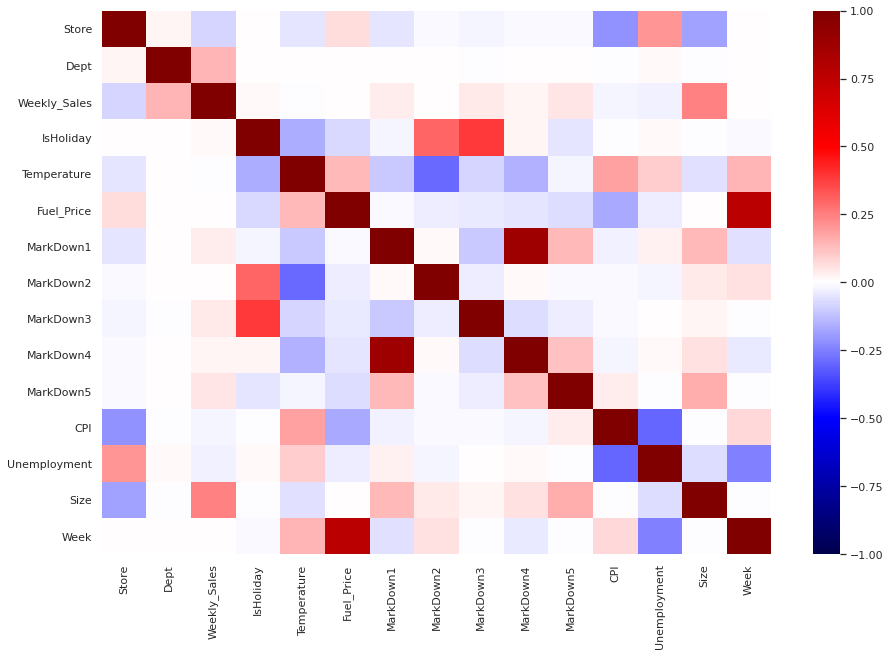

In [15]:
corr_matrix = train.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap = 'seismic')
plt.gca().patch.set(hatch = "X", edgecolor = "#0080ff")
plt.show()

* As seen from graph CPI and unemployment rate are inversely correlated
* Markdown 2 and Temperature are inversely correlated
* There is a slight correlation between Store and CPI, Unemployment rate and Size.
* Week and fuel price are strongly correlated. It tells us that the fuel price are consistently rising.
* MarkDown4 and MarkDown 1 are also stronly correlated.

# Replacing the boolean values in IsHoliday variable 

In [16]:
class replaceBoolean(BaseEstimator, TransformerMixin):
    def __init__(self,arg=None):
        self.arg = arg
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X.loc[X['IsHoliday'] == True, 'IsHoliday'] = 1
        X.loc[X['IsHoliday'] == False, 'IsHoliday'] = 0
        return X

# Encoding Catergorical Features

* "Date" being an ordinal categorical variable. We can keep it as "Week" variable.
* As "Store" and "Dept" have many categories we will use Binary Encoding for them.
* "Type" variable has only 3 classes, hence we will use One Hot Encoding for it.
* "IsHoliday" is a boolen variable hence we will encode it using 1 and 0.

In [17]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

In [18]:
#Creating Pipeline
def runPipeline(data):
    #First transformation
    temp = replaceDateWithWeek()
    data = temp.transform(data)
    
    #Second transformation
    temp = fillMarkDowns()
    data = temp.transform(data)
    
    completePipeline = ColumnTransformer([
        ('binary_encoder', BinaryEncoder(cols = ['Store','Dept'], return_df=True),['Store','Dept']),
        ('one_hot_encoder',ce.OneHotEncoder(),['Type']),
        ('scalar', StandardScaler(),['Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Size']),
        ('boolean_converter',replaceBoolean(),['IsHoliday'])
    ],n_jobs = -1,verbose = True)
    
    data = completePipeline.fit_transform(data)
    data = pd.DataFrame(data, columns = [x for x in range(1,len(data[0])+1)])
    data = data.astype(dtype = np.float64)
    
    return data

# Building Full Pipeline with Final Model

In [41]:
def fullPipeline():
    # Preprocessing and splitting the data into train and test set
    data = pd.read_csv("../input/course-material-walmart-challenge/train.csv")
    weekly_sales = data["Weekly_Sales"].copy()
    data.drop("Weekly_Sales", axis = 1, inplace = True)
    data = runPipeline(data)
    data['Weekly_Sales'] = weekly_sales.tolist()
    X, X_test = train_test_split(data, test_size = 0.2, random_state = 21)
    y = X["Weekly_Sales"].copy()
    y_test = X_test['Weekly_Sales'].copy()
    X.drop(['Weekly_Sales'],axis = 1, inplace = True)
    X_test.drop(['Weekly_Sales'], axis = 1, inplace = True)
    
    # Initializing all the base models.
    rf_reg = RandomForestRegressor(max_depth=232,max_features=23,n_estimators=162)
    ext_reg = ExtraTreesRegressor(max_depth=239,max_features=27,n_estimators=283)
    ext_reg = ExtraTreesRegressor(max_depth=150,max_features=27,n_estimators=283)
    xgb_reg = xgboost.XGBRegressor(eta=0.15,gamma=0,max_depth=13,min_child_weight=5)
    lin_reg = LinearRegression()
    
    # Declaring the parameters of Stacking Regressor
    estimators = [('rf', rf_reg),('ext', ext_reg),('xgb',xgb_reg)]
    final_estimator = lin_reg
    
    # Initializing and fitting the Stacking Regressor
    stacking_reg = StackingRegressor(estimators=estimators,final_estimator=final_estimator,cv = 2)
    stacking_reg.fit(X,y)
    
    # Predicting on the training set
    y_pred = stacking_reg.predict(X)
    stacking_train_mse = mean_squared_error(y, y_pred)
    stacking_train_rmse = np.sqrt(stacking_train_mse)
    print("Training Error = {}".format(stacking_train_rmse))
    acc_stacking_train = round( stacking_reg.score(X, y) * 100, 2)
    print ("Coefficient of determination R^2 of the prediction on the training set: ", str(acc_stacking_train) + ' percent')

    # Predicting on the test set
    y_pred = stacking_reg.predict(X_test)
    stacking_test_mse = mean_squared_error(y_test, y_pred)
    stacking_test_rmse = np.sqrt(stacking_test_mse)
    print("Test Error = {}".format(stacking_test_rmse))
    acc_stacking_test = round( stacking_reg.score(X_test, y_test) * 100, 2)
    print ("Coefficient of determination R^2 of the prediction on the test set: ", str(acc_stacking_test) + ' percent')

In [42]:
fullPipeline()

Number of weeks in the dataset = 143


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies

Training Error = 894.9640210434686


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Coefficient of determination R^2 of the prediction on the training set:  99.84 percent


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Test Error = 3990.015726732953


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Coefficient of determination R^2 of the prediction on the test set:  96.95 percent


In [21]:
# # Importing the whole data and applying the complete pipeline again on the data
# train, test = importData('Date')
# y = train['Weekly_Sales'].copy()
# X_raw = train.drop(['Weekly_Sales'],axis = 1)
# y_test = test['Weekly_Sales'].copy()
# X_test_raw = test.drop(['Weekly_Sales'], axis = 1)
# X = runPipeline(X_raw)
# X_test = runPipeline(X_test_raw)

In [22]:
# X.head(10)

In [23]:
# X.info()

# Trying out various regression models

In [24]:
# lin_reg = LinearRegression()
# rnf_reg = RandomForestRegressor()
# ext_reg = ExtraTreesRegressor()
# voting_reg = VotingRegressor(
#     estimators=[('rf', rnf_reg), ('et', ext_reg)]
# )

In [25]:
# train = X.copy()
# train['Weekly_Sales'] = y.tolist()
# X_train, X_valid = train_test_split(train, test_size = 0.2, random_state = 21)

# y_train = X_train['Weekly_Sales'].copy()
# X_train.drop(["Weekly_Sales"], axis = 1, inplace = True)
# y_valid = X_valid['Weekly_Sales'].copy()
# X_valid.drop(["Weekly_Sales"], axis = 1, inplace = True)


# # for reg in (lin_reg, rnf_reg, ext_reg, voting_reg):
# #     reg.fit(X_train,y_train)
# #     y_pred = reg.predict(X_train)
# #     y_valid_pred = reg.predict(X_valid)
# #     reg_mse = mean_squared_error(y_train, y_pred)
# #     reg_rmse = np.sqrt(reg_mse)
# #     print(reg.__class__.__name__,": ")
# #     print("Training Error = {}".format(reg_rmse))
# #     reg_mse = mean_squared_error(y_valid, y_valid_pred)
# #     reg_rmse = np.sqrt(reg_mse)
# #     print("Validation Error = {}".format(reg_rmse))

# Saving the training and validation data set

In [26]:
# rows = [[x for x in range(1,30)]]
# rows[0].append("Weekly_Sales")
# for i in range(225960):
#     rows.append([train[x][i] for x in range(1,30)])
#     rows[i+1].append(train['Weekly_Sales'][i])
# with open("train.csv", 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(rows)

# Loading the training data set

In [27]:
# train = pd.read_csv("./train.csv")
# train.head()

# Trying out Boosting Algorithms

In [28]:
# #Initializing and fitting the model
# gbrt = GradientBoostingRegressor()
# gbrt.fit(X_train, y_train)

# #Predicting on traing set
# y_pred = gbrt.predict(X_train)
# gbrt_mse = mean_squared_error(y_train, y_pred)
# gbrt_rmse = np.sqrt(gbrt_mse)
# print("Gradient Boosting Regressor Training Error = {}".format(gbrt_rmse))

# #Predicting on validation set
# y_pred = gbrt.predict(X_valid)
# gbrt_mse = mean_squared_error(y_valid, y_pred)
# gbrt_rmse = np.sqrt(gbrt_mse)
# print("Gradient Boosting Regressor Validation Error = {}".format(gbrt_rmse))

In [29]:
# #Initializing and fitting the model
# xgb_reg = xgboost.XGBRegressor()
# xgb_reg.fit(X_train, y_train)

# #Predicting on traing set
# y_pred = xgb_reg.predict(X_train)
# xgb_reg_mse = mean_squared_error(y_train, y_pred)
# xgb_reg_rmse = np.sqrt(xgb_reg_mse)
# print("Extreme Gradient Boosting Regressor Training Error = {}".format(xgb_reg_rmse))

# #Predicting on validation set
# y_pred = xgb_reg.predict(X_valid)
# xgb_reg_mse = mean_squared_error(y_valid, y_pred)
# xgb_reg_rmse = np.sqrt(xgb_reg_mse)
# print("Extreme Gradient Boosting Regressor Validation Error = {}".format(xgb_reg_rmse))

In [30]:
# #Initializing and fitting the model
# ext_reg = ExtraTreesRegressor(n_estimators = 20,max_depth = 15)
# adb_reg = AdaBoostRegressor(base_estimator = ext_reg)
# adb_reg.fit(X_train, y_train)

# #Predicting on traing set
# y_pred = adb_reg.predict(X_train)
# adb_reg_mse = mean_squared_error(y_train, y_pred)
# adb_reg_rmse = np.sqrt(adb_reg_mse)
# print("Adaptive Boosting Regressor Training Error = {}".format(adb_reg_rmse))

# #Predicting on validation set
# y_pred = adb_reg.predict(X_valid)
# adb_reg_mse = mean_squared_error(y_valid, y_pred)
# adb_reg_rmse = np.sqrt(adb_reg_mse)
# print("Adaptive Boosting Regressor Validation Error = {}".format(adb_reg_rmse))

# Fine-Tunning Random Forest Regressor 

In [31]:
# param_distribs = {
#     'n_estimators': randint(low=150, high=300),
#     'max_features': randint(low=15, high=30),
#     'max_depth':randint(low=120, high = 250)
# }

# forest_reg = RandomForestRegressor(random_state=21)
# forest_rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_jobs = -1, return_train_score = True,
#                                 n_iter=15, cv=2, scoring='neg_mean_squared_error', random_state=21)
# forest_rnd_search.fit(X_train,y_train)

# cvres = forest_rnd_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

In [32]:
# Best Params:  {'max_depth': 232, 'max_features': 23, 'n_estimators': 162}
# Random Forest Regressor Validation Error = 5202.5457875042375

# print("Best Params: ", forest_rnd_search.best_params_)
# y_pred = forest_rnd_search.best_estimator_.predict(X_valid)
# forest_mse = mean_squared_error(y_valid, y_pred)
# forest_rmse = np.sqrt(forest_mse)
# print("Random Forest Regressor Validation Error = {}".format(forest_rmse))

# Fine-Tunning Extra Trees Regressor 

In [33]:
# param_distribs = {
#     'n_estimators': randint(low=150, high=300),
#     'max_features': randint(low=15, high=30),
#     'max_depth':randint(low=120, high = 250)
# }

# ext_reg = ExtraTreesRegressor(random_state=21)
# ext_rnd_search = RandomizedSearchCV(ext_reg, param_distributions=param_distribs, n_jobs = -1, return_train_score = True,
#                                 n_iter=15, cv=2, scoring='neg_mean_squared_error', random_state=21)
# ext_rnd_search.fit(X_train,y_train)

# cvres = ext_rnd_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

In [34]:
# Best Params:  {'max_depth': 239, 'max_features': 27, 'n_estimators': 283}

# # Extra Trees Regressor Validation Error = 4782.645726024579
# print("Best Params: ", ext_rnd_search.best_params_)
# y_pred = ext_rnd_search.best_estimator_.predict(X_valid)
# ext_mse = mean_squared_error(y_valid, y_pred)
# ext_rmse = np.sqrt(ext_mse)
# print("Extra Trees Regressor Validation Error = {}".format(ext_rmse))

# Hyperparameter tuning XGBoost

In [35]:
# param_distribs = {
#     'eta':[0.15,0.17,0.19,0.2,0.22,0.24,0.25,0.27,0.29,0.3],
#     'min_child_weight':randint(low = 1, high = 7),
#     'max_depth':randint(low=10, high = 25),
#     'gamma':randint(low = 0,high = 5),
# }

# xgb_reg = xgboost.XGBRegressor()
# xgb_rnd_search = RandomizedSearchCV(xgb_reg, param_distributions=param_distribs, n_jobs = -1, return_train_score = True,
#                                 n_iter=15, cv=2, scoring='neg_mean_squared_error', random_state=21)
# xgb_rnd_search.fit(X_train,y_train)

# cvres = xgb_rnd_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

In [36]:
# Best Params:  {'eta': 0.15, 'gamma': 0, 'max_depth': 13, 'min_child_weight': 5}

# print("Best Params: ", xgb_rnd_search.best_params_)
# y_pred = xgb_rnd_search.best_estimator_.predict(X_valid)
# xgb_mse = mean_squared_error(y_valid, y_pred)
# xgb_rmse = np.sqrt(xgb_mse)
# print("Extra Trees Regressor Validation Error = {}".format(xgb_rmse))

# Implementing Votting Regressor

In [37]:
# Training Error = 939.4560063275186 (ext+xgb)
# Validation Error = 4582.014285496773

# ext_reg = ExtraTreesRegressor(max_depth=239,max_features=27,n_estimators=283)
# xgb_reg = xgboost.XGBRegressor(eta=0.15,gamma=0,max_depth=13,min_child_weight=5)
# voting_reg = VotingRegressor(estimators=[('xgb', xgb_reg), ('et', ext_reg), ('rnf', rnf_reg)])

# voting_reg.fit(X_train, y_train)
# y_pred = voting_reg.predict(X_train)
# voting_train_mse = mean_squared_error(y_train, y_pred)
# voting_train_rmse = np.sqrt(voting_train_mse)
# print("Training Error = {}".format(voting_train_rmse))

In [38]:
# y_pred = voting_reg.predict(X_valid)
# voting_valid_mse = mean_squared_error(y_valid, y_pred)
# voting_valid_rmse = np.sqrt(voting_valid_mse)
# print("Validation Error = {}".format(voting_valid_rmse))

# Implementing Stacking Regressor

In [39]:
# # Training Error = 736.3944328793483
# # Validation Error = 4517.871439867831

# rf_reg = RandomForestRegressor(max_depth=232,max_features=23,n_estimators=162)
# ext_reg = ExtraTreesRegressor(max_depth=239,max_features=27,n_estimators=283)
# xgb_reg = xgboost.XGBRegressor(eta=0.15,gamma=0,max_depth=13,min_child_weight=5)
# lin_reg = LinearRegression()

# estimators = [('rf', rf_reg),('ext', ext_reg),('xgb',xgb_reg)]
# final_estimator = lin_reg

# stacking_reg = StackingRegressor(estimators=estimators,final_estimator=final_estimator,cv = 2)
# stacking_reg.fit(X_train,y_train)

# y_pred = stacking_reg.predict(X_train)
# stacking_train_mse = mean_squared_error(y_train, y_pred)
# stacking_train_rmse = np.sqrt(stacking_train_mse)
# print("Training Error = {}".format(stacking_train_rmse))
# acc_stacking_train = round( stacking_reg.score(X_train, y_train) * 100, 2)
# print ("Coefficient of determination R^2 of the prediction on the test set: ", str(acc_stacking_train) + ' percent')
    
# y_pred = stacking_reg.predict(X_valid)
# stacking_valid_mse = mean_squared_error(y_valid, y_pred)
# stacking_valid_rmse = np.sqrt(stacking_valid_mse)
# print("Validation Error = {}".format(stacking_valid_rmse))
# acc_stacking_test = round( stacking_reg.score(X_valid, y_valid) * 100, 2)
# print ("Coefficient of determination R^2 of the prediction on the test set: ", str(acc_stacking_test) + ' percent')